In [1]:
import pandas as pd
import numpy as np 
import joblib

from sklearn.preprocessing import MinMaxScaler,StandardScaler,RobustScaler
from sklearn.metrics import mean_absolute_error,mean_squared_error,r2_score
from sklearn.pipeline import Pipeline
from sklearn.model_selection import TimeSeriesSplit,GridSearchCV, train_test_split
from sklearn.ensemble import RandomForestRegressor
from sklearn.linear_model import LinearRegression,Lasso,Ridge  
from sklearn.neighbors import KNeighborsRegressor 
from sklearn.tree import DecisionTreeRegressor 
from xgboost import XGBRegressor 
from sklearn.svm import SVR 
from sklearn.neural_network import MLPRegressor

from sklearn.metrics import make_scorer

## Tratamento dos Dados

##### Como nosso objetivo é predizer a temperatura duas horas a frente, precisamos que nosso modelo consiga fazer a predição da temperatura futura. <br><br> Para tal, foi criada uma nova coluna utilizando a função shift para deslizar todos os valores duas horas à frente. Essa coluna é adicionada ao dataframe e a mesma será o valor a ser predito.

In [3]:
df_temperatura = pd.read_csv("..\db\clima_tratado.csv", sep=',')

In [4]:
df_temperatura['temp_lag_2'] = df_temperatura['T (degC)'].shift(2)
df_temperatura = df_temperatura.dropna(axis=0)
df_temperatura

,DateTime,p (mbar),T (degC),Tpot (K),Tdew (degC),rh (%),VPmax (mbar),VPact (mbar),VPdef (mbar),sh (g/kg),H2OC (mmol/mol),rho (g/m**3),wv (m/s),max. wv (m/s),wd (deg),temp_lag_2
2,2009-01-01 03:00:00,996.84,-8.81,264.59,-9.66,93.50,3.13,2.93,0.20,1.83,2.94,1312.18,0.18,0.63,167.20,-8.05
3,2009-01-01 04:00:00,996.99,-9.05,264.34,-10.02,92.60,3.07,2.85,0.23,1.78,2.85,1313.61,0.10,0.38,240.00,-8.88
4,2009-01-01 05:00:00,997.46,-9.63,263.72,-10.65,92.20,2.94,2.71,0.23,1.69,2.71,1317.19,0.40,0.88,157.00,-8.81
5,2009-01-01 06:00:00,997.71,-9.67,263.66,-10.62,92.70,2.93,2.71,0.21,1.69,2.72,1317.71,0.05,0.50,146.00,-9.05
6,2009-01-01 07:00:00,998.33,-9.17,264.12,-10.10,92.90,3.04,2.83,0.22,1.76,2.83,1315.98,2.08,2.88,348.80,-9.63
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
70087,2016-12-31 20:00:00,1001.47,-1.52,271.52,-7.13,65.42,5.46,3.57,1.89,2.22,3.57,1282.60,1.24,1.96,232.00,-0.08
70088,2016-12-31 21:00:00,1001.29,-3.09,269.98,-7.09,73.70,4.86,3.58,1.28,2.23,3.58,1289.78,0.61,1.48,207.50,-1.03
70089,2016-12-31 22:00:00,1000.70,-2.59,270.51,-7.04,71.30,5.04,3.60,1.45,2.24,3.59,1286.67,0.38,0.72,8.15,-1.52
70090,2016-12-31 23:00:00,1000.21,-3.76,269.39,-7.95,72.50,4.62,3.35,1.27,2.09,3.35,1291.71,0.89,1.30,223.70,-3.09


In [5]:
df_temperatura.set_index('DateTime',inplace=True)
df_temperatura

,p (mbar),T (degC),Tpot (K),Tdew (degC),rh (%),VPmax (mbar),VPact (mbar),VPdef (mbar),sh (g/kg),H2OC (mmol/mol),rho (g/m**3),wv (m/s),max. wv (m/s),wd (deg),temp_lag_2
DateTime,,,,,,,,,,,,,,,
2009-01-01 03:00:00,996.84,-8.81,264.59,-9.66,93.50,3.13,2.93,0.20,1.83,2.94,1312.18,0.18,0.63,167.20,-8.05
2009-01-01 04:00:00,996.99,-9.05,264.34,-10.02,92.60,3.07,2.85,0.23,1.78,2.85,1313.61,0.10,0.38,240.00,-8.88
2009-01-01 05:00:00,997.46,-9.63,263.72,-10.65,92.20,2.94,2.71,0.23,1.69,2.71,1317.19,0.40,0.88,157.00,-8.81
2009-01-01 06:00:00,997.71,-9.67,263.66,-10.62,92.70,2.93,2.71,0.21,1.69,2.72,1317.71,0.05,0.50,146.00,-9.05
2009-01-01 07:00:00,998.33,-9.17,264.12,-10.10,92.90,3.04,2.83,0.22,1.76,2.83,1315.98,2.08,2.88,348.80,-9.63
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
2016-12-31 20:00:00,1001.47,-1.52,271.52,-7.13,65.42,5.46,3.57,1.89,2.22,3.57,1282.60,1.24,1.96,232.00,-0.08
2016-12-31 21:00:00,1001.29,-3.09,269.98,-7.09,73.70,4.86,3.58,1.28,2.23,3.58,1289.78,0.61,1.48,207.50,-1.03
2016-12-31 22:00:00,1000.70,-2.59,270.51,-7.04,71.30,5.04,3.60,1.45,2.24,3.59,1286.67,0.38,0.72,8.15,-1.52


##### Separação da coluna com as entradas e os valores de saída 

In [6]:
#Separando as colunas
X = df_temperatura.drop(['temp_lag_2'],axis=1)
Y = df_temperatura['temp_lag_2'].ravel()

#### Utilização de uma normalização com as variáveis de entrada para que evitar a ocorrência de alguns atributos terem o peso maior do que outros

In [6]:
#Definindo a normalização utilizada
preprocessing = MinMaxScaler(feature_range=(0,1))


#### As métricas utilizados para avaliar o desempenho dos modelos de regressão foram:

- **MAE** (Erro Absoluto Médio): calcula o "erro absoluto médio" dos erros entre valores observados (reais) e predições (hipóteses). Quanto maior seu valor, pior o desempenho do modelo.
- **MSE** (Erro quadrado médio): Mede o erro ao quadrado médio das previsões do modelo. MSE calcula a diferença ao quadrado entre o resultado observado (real) e os valores previstos e depois calcula a média. Quanto maior seu valor, pior o desempenho do modelo.
- **R²**: expressa a porcentagem de variância explicada pelas variáveis independentes apresentadas no modelo. Quando maior, melhor o desempenho dele. <br> 

In [21]:
#Definindo as metricas utilizadas para comparar os modelos 
mse_scorer = make_scorer(mean_squared_error,greater_is_better=False)
mae_scorer = make_scorer(mean_absolute_error,greater_is_better=False)
r2_scorer = make_scorer(r2_score,greater_is_better=True)

metricas = {'mse':mean_squared_error, 'mae':mean_absolute_error,'r2':r2_score}
metricas2 = {'mse':mse_scorer, 'mae':mae_scorer,'r2':r2_scorer}

##### Os  modelos escolhidos foram:
- **Regressão Linear**;
- **Regressão Ridge**;
- **Regressão Lasso**;
- **KNN**;
- **Árvore de Decisão**;
- **Gradient Boosting**.
- **Random Forest**;
- **SVM**;
- **Redes Neurais**;

##### Foram também definidos alguns hiperparâmetros para cada modelo a fim de, através da busca em grade, encontrar os melhores valores para o melhor desempenho de cada modelo.

In [22]:
#Definição dos modelos e parametros utilizados por cada um deles
model = [
    ('RandomForestRegressor', RandomForestRegressor()),
    ('LinearRegression', LinearRegression()),
    ('Ridge', Ridge()),
    ('Lasso', Lasso()),
    ('SVR', SVR()),
    ('MLPRegressor',MLPRegressor()),
    ('XGBoost',XGBRegressor()),
    ('DecisionTreeRegressor',DecisionTreeRegressor()),
    ('KNeighborsRegressor',KNeighborsRegressor())
    
]

param_grid = [
    {
        'model': [RandomForestRegressor()],
        'model__n_estimators': [10, 50, 100],
        'model__max_depth': [5, 10, 15]
    },
    {
        'model': [LinearRegression()],
        'model__fit_intercept': [True, False]
    },
    {
        'model': [Ridge()],
        'model__alpha': [0.1, 0.5, 1.0]
    },
    {
        'model': [Lasso()],
        'model__alpha': [0.1, 0.5, 1.0]
    },
    {
        'model': [SVR()],
        'model__C': [0.1, 1.0, 10.0],
        'model__kernel': ['linear', 'poly', 'rbf']
    },
    {
        'model': [MLPRegressor()],
        'model__hidden_layer_sizes': [(10,), (50,), (100,)],
        'model__activation': ['identity', 'logistic', 'tanh', 'relu'],
        'model__max_iter': [1000]
    },
    {   'model':[XGBRegressor()],
        'model__learning_rate': [0.05, 0.1, 0.2],
        'model__n_estimators' : [100, 200, 300, 500],
        'model__max_depth'    : [5, 10, 20, 30, 40],
        'model__min_child_weight': [1, 3, 5, 10]
    },
    {   'model': [DecisionTreeRegressor()],
        "model__splitter":["best","random"],
        "model__max_depth" : [3,5,8,10,15],
        "model__max_leaf_nodes":[None,10,20,30,40,50,60],
        "model__min_samples_leaf": np.linspace(0.1, 0.5, 6),
        "model__max_features": ["log2", "sqrt"],
        "model__criterion": ["friedman_mse", "squared_error"]
    },
    {   'model': [KNeighborsRegressor()],
        'model__n_neighbors': np.arange(3, 17, 2),
        'model__weights': ['uniform', 'distance'],
        'model__metric': ['euclidean', 'manhattan'],
        'model__leaf_size': [10, 20, 30, 40, 50]
    }
]

In [23]:
#Criação do pipeline
pipe = Pipeline([
    ('preprocesing',preprocessing),
    ('model',model)
])

In [24]:
#Criação dos parametros de busca por grade para encontrar o melhor modelo e parametros
grid = GridSearchCV(pipe, param_grid, cv=TimeSeriesSplit(n_splits=3), scoring=metricas2,refit='r2', return_train_score=True, verbose=3)

In [7]:
#Divisão em treino e teste
X_train, X_test, Y_train, Y_test = train_test_split(X,Y,test_size=0.2,shuffle=False)
print(X_train.shape, X_test.shape, Y_train.shape, Y_test.shape)

(56072, 14) (14018, 14) (56072,) (14018,)


In [26]:
#Treinamento dos modelos
grid.fit(X_train,Y_train)

Fitting 3 folds for each of 2098 candidates, totalling 6294 fits
[CV 1/3] END model=RandomForestRegressor(), model__max_depth=5, model__n_estimators=10; mae: (train=-1.276, test=-1.266) mse: (train=-3.138, test=-3.214) r2: (train=0.962, test=0.956) total time=   0.5s
[CV 2/3] END model=RandomForestRegressor(), model__max_depth=5, model__n_estimators=10; mae: (train=-1.268, test=-1.304) mse: (train=-3.162, test=-3.272) r2: (train=0.960, test=0.954) total time=   1.0s
[CV 3/3] END model=RandomForestRegressor(), model__max_depth=5, model__n_estimators=10; mae: (train=-1.273, test=-1.233) mse: (train=-3.184, test=-3.023) r2: (train=0.959, test=0.941) total time=   1.6s
[CV 1/3] END model=RandomForestRegressor(), model__max_depth=5, model__n_estimators=50; mae: (train=-1.265, test=-1.260) mse: (train=-3.100, test=-3.179) r2: (train=0.963, test=0.957) total time=   2.7s
[CV 2/3] END model=RandomForestRegressor(), model__max_depth=5, model__n_estimators=50; mae: (train=-1.263, test=-1.301) ms

c:\Users\gabry\OneDrive\Documentos\Meus_Projetos\Challenge - FIEC\fiec\.venv\lib\site-packages\sklearn\neural_network\_multilayer_perceptron.py:684: ConvergenceWarning: Stochastic Optimizer: Maximum iterations (1000) reached and the optimization hasn't converged yet.
  warnings.warn(


[CV 1/3] END model=MLPRegressor(), model__activation=logistic, model__hidden_layer_sizes=(10,), model__max_iter=1000; mae: (train=-1.224, test=-1.205) mse: (train=-2.934, test=-2.911) r2: (train=0.965, test=0.961) total time=  20.1s
[CV 2/3] END model=MLPRegressor(), model__activation=logistic, model__hidden_layer_sizes=(10,), model__max_iter=1000; mae: (train=-1.201, test=-1.206) mse: (train=-2.819, test=-2.783) r2: (train=0.964, test=0.961) total time=  24.8s
[CV 3/3] END model=MLPRegressor(), model__activation=logistic, model__hidden_layer_sizes=(10,), model__max_iter=1000; mae: (train=-1.187, test=-1.150) mse: (train=-2.763, test=-2.618) r2: (train=0.965, test=0.948) total time=  47.1s


c:\Users\gabry\OneDrive\Documentos\Meus_Projetos\Challenge - FIEC\fiec\.venv\lib\site-packages\sklearn\neural_network\_multilayer_perceptron.py:684: ConvergenceWarning: Stochastic Optimizer: Maximum iterations (1000) reached and the optimization hasn't converged yet.
  warnings.warn(


[CV 1/3] END model=MLPRegressor(), model__activation=logistic, model__hidden_layer_sizes=(50,), model__max_iter=1000; mae: (train=-1.192, test=-1.191) mse: (train=-2.703, test=-2.755) r2: (train=0.967, test=0.963) total time=  59.9s
[CV 2/3] END model=MLPRegressor(), model__activation=logistic, model__hidden_layer_sizes=(50,), model__max_iter=1000; mae: (train=-1.201, test=-1.207) mse: (train=-2.806, test=-2.765) r2: (train=0.964, test=0.961) total time=  44.1s
[CV 3/3] END model=MLPRegressor(), model__activation=logistic, model__hidden_layer_sizes=(50,), model__max_iter=1000; mae: (train=-1.157, test=-1.123) mse: (train=-2.561, test=-2.417) r2: (train=0.967, test=0.952) total time= 2.2min
[CV 1/3] END model=MLPRegressor(), model__activation=logistic, model__hidden_layer_sizes=(100,), model__max_iter=1000; mae: (train=-1.251, test=-1.221) mse: (train=-3.085, test=-3.036) r2: (train=0.963, test=0.959) total time=  20.0s
[CV 2/3] END model=MLPRegressor(), model__activation=logistic, mode

GridSearchCV(cv=TimeSeriesSplit(gap=0, max_train_size=None, n_splits=3, test_size=None),
             estimator=Pipeline(steps=[('preprocesing', MinMaxScaler()),
                                       ('model',
                                        [('RandomForestRegressor',
                                          RandomForestRegressor()),
                                         ('LinearRegression',
                                          LinearRegression()),
                                         ('Ridge', Ridge()), ('Lasso', Lasso()),
                                         ('SVR', SVR()),
                                         ('MLPRegressor', MLPRegressor()),
                                         ('XGBoost',
                                          XGBRegressor(b...
                          'model__leaf_size': [10, 20, 30, 40, 50],
                          'model__metric': ['euclidean', 'manhattan'],
                          'model__n_neighbors': array([ 3,  5,  7,  9, 11, 13, 15]),
                          'model__weights': ['uniform', 'distance']}],
             refit='r2', return_train_score=True,
             scoring={'mae': make_scorer(mean_absolute_error, greater_is_better=False),
                      'mse': make_scorer(mean_squared_error, greater_is_better=False),
                      'r2': make_scorer(r2_score)},
             verbose=3)

In [27]:
#Imprimindo os melhores parâmetros e métricas de avaliação
print("Melhores parâmetros: ", grid.best_params_)
print("Melhor métrica R2: ", grid.best_score_)

Melhores parâmetros:  {'model': XGBRegressor(base_score=None, booster=None, callbacks=None,
             colsample_bylevel=None, colsample_bynode=None,
             colsample_bytree=None, early_stopping_rounds=None,
             enable_categorical=False, eval_metric=None, feature_types=None,
             gamma=None, gpu_id=None, grow_policy=None, importance_type=None,
             interaction_constraints=None, learning_rate=0.05, max_bin=None,
             max_cat_threshold=None, max_cat_to_onehot=None,
             max_delta_step=None, max_depth=5, max_leaves=None,
             min_child_weight=10, missing=nan, monotone_constraints=None,
             n_estimators=300, n_jobs=None, num_parallel_tree=None,
             predictor=None, random_state=None, ...), 'model__learning_rate': 0.05, 'model__max_depth': 5, 'model__min_child_weight': 10, 'model__n_estimators': 300}
Melhor métrica (MSE):  0.9623729649942359


>**Comentário**: O modelo que apresentou o melhor resultado foi o Gradient Boosting, com o coeficiente de determinação no valor de 0.96.

##### Aplicação do modelo e verificação das métricas na base de teste.

In [ ]:
# Fazendo as previsões com o melhor modelo
best_model = grid.best_estimator_
Y_pred = best_model.predict(X_test)

In [29]:
# Calculando as métricas de avaliação no conjunto de teste
mse = mean_squared_error(Y_test, Y_pred)
r2 = r2_score(Y_test, Y_pred)
mae = mean_absolute_error(Y_test, Y_pred)

print("MSE: ", mse)
print("R2: ", r2)
print("MAE: ", mae)

MSE:  2.403806302011443
R2:  0.9632806703548327
MAE:  1.1223322776778635


In [33]:
print(Y_test)
print(Y_pred)

[17.93 16.92 15.82 ... -1.52 -3.09 -2.59]
[18.48343   16.500612  15.510152  ... -1.5385993 -3.657398  -5.4520445]


In [31]:
#gravação do modelo treinado
joblib.dump(best_model, '../models/best_model_temp_2.joblib')

['../models/best_model_temp_2.joblib']

In [8]:
#Carregando o modelo treinado
modelo = joblib.load('../models/best_model_temp_2.joblib')

In [9]:
Y_predict = modelo.predict(X_test)

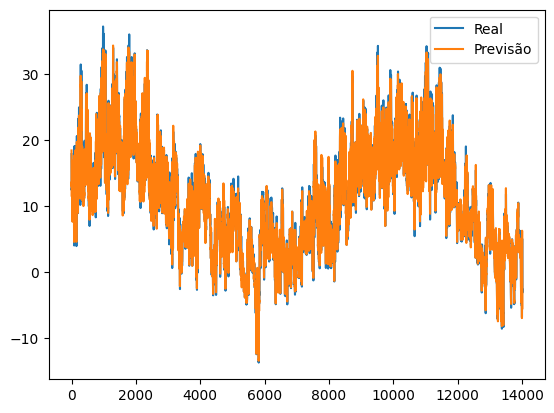

In [14]:
# Gráfico para visualizar os valores reais e os previstos pelo modelo
import matplotlib.pyplot as plt
plt.plot(Y_test)
plt.plot(Y_predict)
plt.legend(["Real","Previsão"])
plt.show()

In [13]:
#Tabela para a visualização dos valores reais e os previstos
resultados = {'Real':Y_test, 'Previsao':Y_predict}
df_resultado = pd.DataFrame(resultados)
df_resultado

,Real,Previsao
0,17.93,18.483431
1,16.92,16.500612
2,15.82,15.510152
3,15.02,14.046124
4,14.14,13.906175
...,...,...
14013,-0.08,-1.070870
14014,-1.03,-3.177981
14015,-1.52,-1.538599
14016,-3.09,-3.657398
